Generate list of samples to use for QA checks for temporal consistency

In [1]:
%load_ext lab_black

In [2]:
from datetime import timedelta

from cloudpathlib import AnyPath
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from shapely.geometry import Point

from cyano.data.utils import add_unique_identifier

In [3]:
EXPERIMENT_DIR = Path("../experiments/results/temporal_qa_checks/")
EXPERIMENT_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
df = pd.read_csv(
    AnyPath(
        "s3://drivendata-competition-nasa-cyanobacteria/experiments/splits/competition/test.csv"
    )
)
df = add_unique_identifier(df)
df["date"] = pd.to_datetime(df.date)
df.head(3)

,uid,data_provider,region,latitude,longitude,date,density_cells_per_ml,severity,distance_to_water_m,log_density
sample_id,,,,,,,,,,
4a89ead93e2caa84da636236bb361e12,aabn,California Environmental Data Exchange Network,west,36.559700,-121.51000,2016-08-31,5.867500e+06,4,3512.0,15.584939
a7e2d76f204ac347ae5529557eb7f665,aair,California Environmental Data Exchange Network,west,33.042600,-117.07600,2014-11-01,2.769000e+06,4,195.0,14.833997
6afcb31acb56fc25af76983df6a60d0a,aajw,US Army Corps of Engineers,northeast,40.703968,-80.29305,2015-08-26,2.451087e+03,1,0.0,7.804695


In [5]:
# Make sure our sample ids match up with existing imagery
satmeta = pd.read_csv("../experiments/cache/satellite_metadata_test.csv")
satmeta.sample_id.drop_duplicates().isin(df.index).value_counts()

sample_id
True    3745
Name: count, dtype: int64

### Select subset of samples

In [6]:
# subset to points in water bodies
subset = df[df.distance_to_water_m == 0].reset_index(drop=False)
print(f"Narrowed to {subset.shape[0]:,} samples in water")

# only have max 1 example at each location
subset = subset.sample(frac=1, random_state=3)
subset = subset.groupby(["latitude", "longitude"], as_index=False).first()
print(f"Narrowed to {subset.shape[0]:,} unique locations")

# take some from each region
subset = pd.concat(
    [
        subset[subset.region == region].sample(n=8, random_state=2)
        for region in subset.region.unique()
    ]
)

subset.head(3)

Narrowed to 2,680 samples in water
Narrowed to 850 unique locations


,latitude,longitude,sample_id,uid,data_provider,region,date,density_cells_per_ml,severity,distance_to_water_m,log_density
172,36.50000,-79.066285,03b6a9b387cb12b74f337ce426551eea,nmdb,N.C. Division of Water Resources N.C. Departme...,south,2019-05-28,16011.0,1,0.0,9.681094
249,39.49277,-79.794220,fcb82e75f805298e8f61cf3bc561a1be,ihyj,EPA National Aquatic Research Survey,south,2017-08-23,296870.0,3,0.0,12.601053
153,36.50000,-79.067225,e716d756a146e750124a30b486217461,ryeu,N.C. Division of Water Resources N.C. Departme...,south,2019-09-19,1452.0,1,0.0,7.281386


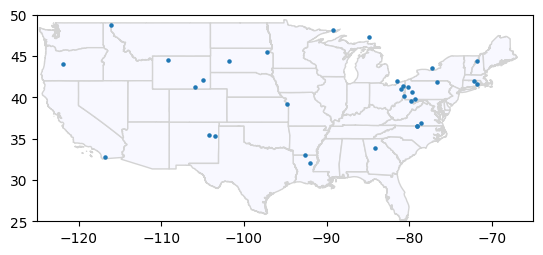

In [7]:
# see on a map where these samples are
_, ax = plt.subplots()

STATES_SHAPEFILE = gpd.GeoDataFrame.from_file(
    "../../competition-nasa-cyanobacteria/data/raw/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
)
STATES_SHAPEFILE.plot(color="ghostwhite", edgecolor="lightgray", ax=ax)

geometry = [Point(xy) for xy in zip(subset.longitude, subset.latitude)]
gdf = gpd.GeoDataFrame(subset, geometry=geometry)
gdf.plot(ax=ax, markersize=5)

ax.set_xlim([-125, -65])
ax.set_ylim([25, 50])
plt.show()

In [8]:
subset.severity.value_counts().sort_index()

severity
1    17
2     5
3    10
Name: count, dtype: int64

### Add temporal checks

Add additional rows around each sample spanning 4 weeks

In [9]:
predict_df = []

for sample in subset.itertuples():
    predict_df.append(
        pd.DataFrame(
            {
                "latitude": sample.latitude,
                "longitude": sample.longitude,
                # 4 week range for each sample
                # 7 days between samples
                "date": pd.date_range(
                    start=sample.date - timedelta(days=14),
                    end=sample.date + timedelta(days=14),
                    freq="7d",
                    inclusive="both",
                ),
                "region": sample.region,
                "original_sample_id": sample.sample_id,
            }
        )
    )

predict_df = pd.concat(predict_df)
predict_df.shape

(160, 5)

In [10]:
predict_df

,latitude,longitude,date,region,original_sample_id
0,36.50000,-79.066285,2019-05-14,south,03b6a9b387cb12b74f337ce426551eea
1,36.50000,-79.066285,2019-05-21,south,03b6a9b387cb12b74f337ce426551eea
2,36.50000,-79.066285,2019-05-28,south,03b6a9b387cb12b74f337ce426551eea
3,36.50000,-79.066285,2019-06-04,south,03b6a9b387cb12b74f337ce426551eea
4,36.50000,-79.066285,2019-06-11,south,03b6a9b387cb12b74f337ce426551eea
...,...,...,...,...,...
0,41.29195,-80.182700,2019-08-15,northeast,55361eb671a5ff01c928dd490d7f120b
1,41.29195,-80.182700,2019-08-22,northeast,55361eb671a5ff01c928dd490d7f120b
2,41.29195,-80.182700,2019-08-29,northeast,55361eb671a5ff01c928dd490d7f120b
3,41.29195,-80.182700,2019-09-05,northeast,55361eb671a5ff01c928dd490d7f120b


In [11]:
# some likely won't find satellite imagery
predict_df.original_sample_id.isin(satmeta.sample_id).value_counts()

original_sample_id
True     140
False     20
Name: count, dtype: int64

In [12]:
save_to = EXPERIMENT_DIR / "samples.csv"
save_to.parent.mkdir(exist_ok=True, parents=True)

predict_df.to_csv(save_to, index=False)

print(f"Samples for prediction saved to {save_to}")

Samples for prediction saved to ../experiments/results/temporal_qa_checks/samples.csv


To generate predictions:

`python cyano/cli.py predict experiments/results/temporal_qa_checks/samples.csv --output-path experiments/results/temporal_qa_checks/preds.csv`